## Processing data for Pate Skene

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import colorConverter
from sklearn.neighbors import NearestNeighbors
import pickle as pkl
import loompy

from cytograph.plotting.colors import colors75


def manifold(ds: loompy.LoomConnection, out_file: str, tag1: List[str] = None, tag2: List[str] = None, embedding: str = "TSNE", feature: str = "cluster") -> None:
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding][:, :2]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca[feature]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
    # Compute a good size for the markers, based on local density
    min_pts = min(int(n_cells / 3), 50)
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)

    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_axes([0, 0, 0.4, 1])

    # Draw nodes
    plots = []
    tag1_names = []
    tag2_names = []
    for i in range(max(labels) + 1):
        cluster = labels == i
        n_cells = cluster.sum()
        if np.all(outliers[labels == i] == 1):
            edgecolor = colorConverter.to_rgba('red', alpha=.1)
            plots.append(plt.scatter(x=pos[outliers == 1, 0], y=pos[outliers == 1, 1], c='grey', marker='.', edgecolors=edgecolor, alpha=0.1, s=epsilon))
            tag1_names.append(f"{i}/n={n_cells}  (outliers)")
        else:
            plots.append(plt.scatter(x=pos[cluster, 0], y=pos[cluster, 1], c=[colors75[np.mod(i, 75)]], marker='.', lw=0, s=epsilon, alpha=0.5))
            txt = str(i)
            if "ClusterName" in ds.ca:
                txt = ds.ca.ClusterName[ds.ca[feature] == i][0]
            elif 'Class_labels' in ds.ca:
                txt = ds.ca.Class_labels[ds.ca[feature] == i][0]
            if tag1 is not None:
                tag1_names.append(f"{txt}/n={n_cells} " + tag1[i].replace("\n", " "))
            else:
                tag1_names.append(f"{txt}/n={n_cells}")
            if tag2 is not None:
                tag2_names.append(f"{txt} " + tag2[i].replace("\n", " "))

    # Add legends
    if ds.ca[feature].max() <= 500:
        ax2 = fig.add_axes([0.4, 0, 0.3, 1])
        ax2.axis("off")
        ax2.legend(plots, tag1_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)
        if tag2 is not None:
            ax3 = fig.add_axes([0.7, 0, 0.3, 1])
            ax3.axis("off")
            ax3.legend(plots, tag2_names, scatterpoints=1, markerscale=2, loc='center', mode='expand', fancybox=True, framealpha=0.5, fontsize=12)

    for lbl in range(0, max(labels) + 1):
        txt = str(lbl)
        if "ClusterName" in ds.ca:
            txt = ds.ca.ClusterName[ds.ca[feature] == lbl][0]
        elif 'Class_labels' in ds.ca:
            txt = ds.ca.Class_labels[ds.ca[feature] == lbl][0]
        if np.all(outliers[labels == lbl] == 1):
            continue
        if np.sum(labels == lbl) == 0:
            continue
        (x, y) = np.median(pos[np.where(labels == lbl)[0]], axis=0)
        ax.text(x, y, txt, fontsize=12, bbox=dict(facecolor='white', alpha=0.5, ec='none'))

    ax.axis("off")
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')
    plt.close()

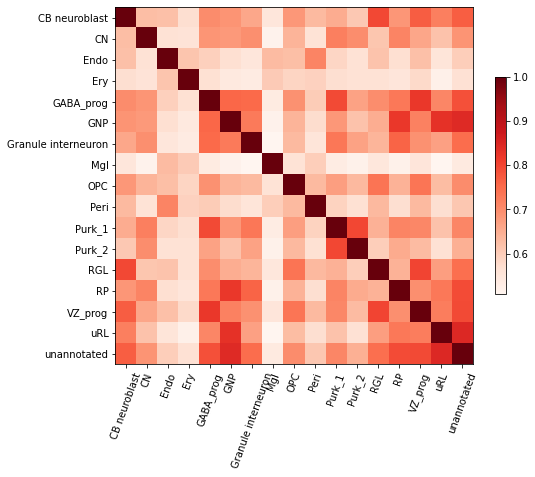

In [67]:
import os, sys, glob
import numpy as np
from pybedtools import BedTool
import matplotlib.pyplot as plt

fdir1 = '/datb/sl/camiel/HARs/CB_Skene/Share_20220215/fixed/beds'

files1 = sorted(glob.glob(os.path.join(fdir1, '*.bed')))
files1.pop(0)
clusters = [x.split('/')[-1].split('.')[0] for x in files1]

X = np.zeros((len(files1), len(files1)))

for i in range(len(files1)):
    for j in range(len(files1)):
        if i >=j:
            bd1 = BedTool(files1[i])
            bd2 = BedTool(files1[j])

            overlap = bd1.intersect(bd2).count()
#             total = bd1.cat(bd2).count()    
#             X[i,j] = overlap/total

            totals = [bd1.count(), bd2.count()]
            X[i,j] = overlap/min(totals)

for i in range(len(files1)):
    for j in range(len(files1)):
        if j > i:
            X[i,j] = X[j,i]

fig, ax = plt.subplots(figsize=(8,8))
im  = ax.imshow(X, cmap='Reds');
fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters, rotation=70);
ax.set_yticklabels(clusters);


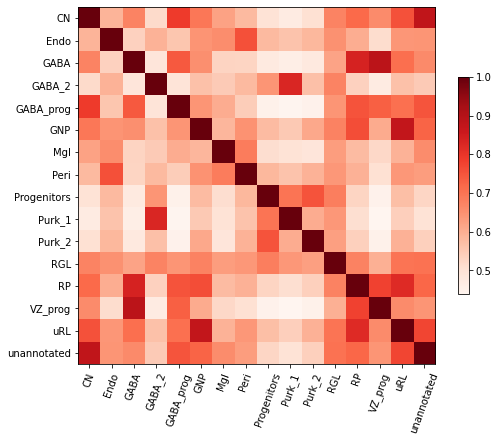

In [85]:
import os, sys, glob
import numpy as np
from pybedtools import BedTool
import matplotlib.pyplot as plt

fdir2 = '/datb/sl/camiel/HARs/CB_Skene/Share_20211015/beds/'

files1 = sorted(glob.glob(os.path.join(fdir2, '*.bed')))
files1.pop(0)
clusters = [x.split('/')[-1].split('.')[0] for x in files1]

X = np.zeros((len(files1), len(files1)))

for i in range(len(files1)):
    for j in range(len(files1)):
        if i >=j:
            bd1 = BedTool(files1[i])
            bd2 = BedTool(files1[j])

            overlap = bd1.intersect(bd2).count()
            total = bd1.cat(bd2).count()
            X[i,j] = overlap/total
            
#             totals = [bd1.count(), bd2.count()]
#             X[i,j] = overlap/min(totals)
for i in range(len(files1)):
    for j in range(len(files1)):
        if j > i:
            X[i,j] = X[j,i]

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(X, cmap='Reds');
fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters, rotation=70);
ax.set_yticklabels(clusters);

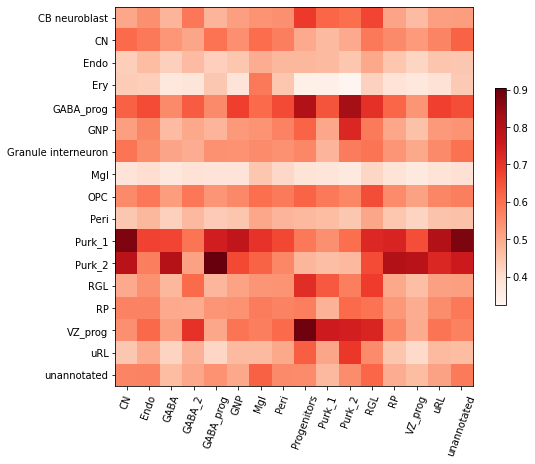

In [83]:
fdir1 = '/datb/sl/camiel/HARs/CB_Skene/Share_20220215/variable/beds/'
fdir2 = '/datb/sl/camiel/HARs/CB_Skene/Share_20211015/beds/'

files1 = sorted(glob.glob(os.path.join(fdir1, '*.bed')))
files1.pop(0)
files2 = sorted(glob.glob(os.path.join(fdir2, '*.bed')))
files2.pop(0)
clusters1 = [x.split('/')[-1].split('.')[0] for x in files1]
clusters2 = [x.split('/')[-1].split('.')[0] for x in files2]

X = np.zeros((len(files1), len(files2)))

for i in range(len(files1)):
    for j in range(len(files2)):
        bd1 = BedTool(files1[i])
        bd2 = BedTool(files2[j])

        overlap = bd1.intersect(bd2).count()
        total = bd1.cat(bd2).count()
        
        X[i,j] = overlap/total

#         totals = [bd1.count(), bd2.count()]
#         X[i,j] = overlap/min(totals)
            
order = np.argmax(X, axis=1)  
fig, ax = plt.subplots(figsize=(8,8));
im  = ax.imshow(X, cmap='Reds');
plt.xticks(np.arange(len(clusters2)), clusters2, rotation=70);
plt.yticks(np.arange(len(clusters1)), clusters1);
fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)



In [106]:
from collections import Counter
from scipy.spatial.distance import jaccard

f1 = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum_old2/Cerebellum_peaks.loom'
f2 = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum_20220215/Cerebellum_peaks.loom'

with loompy.connect(f1, 'r') as ds:
    with loompy.connect(f2, 'r') as ds2:
        IDs = ds.ca.CellID
        IDs2 = ds2.ca.CellID
        X = set(IDs2)
        valid = np.array([x in X for x in IDs])
        valid_IDs = IDs[valid]
        IDs = ds.ca.CellID[np.where(valid)[0]]
        classes1 = ds.ca.Class_labels[np.where(valid)[0]]
        print(np.sum(valid), ds.shape[1])
        print(ds2.shape)
    
        X2 = set(IDs)
        valid2 = np.array([x in X2 for x in IDs2])
        
        classes2 = ds2.ca.Class_labels[np.where(valid2)[0]]
        IDs2 = ds2.ca.CellID[np.where(valid2)[0]]
        
        ## Reorder
        r = np.argsort(IDs)
        IDs = IDs[r]
        classes1 = classes1[r]
        
        r = np.argsort(IDs2)
        IDs2 = IDs2[r]
        classes2 = classes2[r]
        
        
labels1 = sorted(np.unique(classes1))
labels2 = sorted(np.unique(classes2))

X = np.zeros((len(labels1), len(labels2)))

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        a = [x == labels1[i] for x in classes1]
        b = [x == labels2[j] for x in classes2]
        
        X[i,j] = 1 - jaccard(a,b)

61656 77879
(302136, 113470)


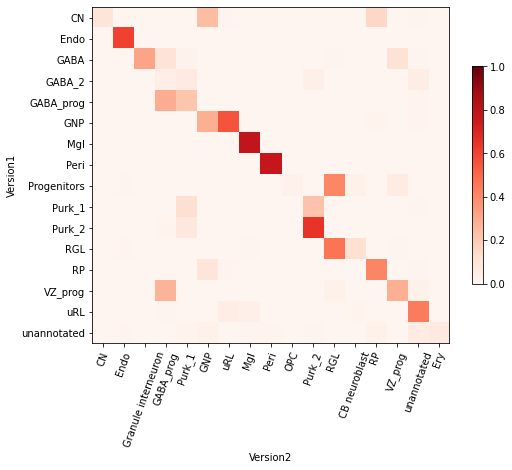

In [107]:
order = np.argsort(np.argmax(X, axis=0))
fig, ax = plt.subplots(1,1,figsize=(8,8))
im = ax.imshow(X[:,order], cmap='Reds', vmax=1, vmin=0)
plt.xticks(np.arange(len(labels2)), np.array(labels2)[order], rotation=70);
plt.yticks(np.arange(len(labels1)), labels1);
plt.ylabel('Version1');
plt.xlabel('Version2');

fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)

['Age', 'AutoAnnotation', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Clusters', 'Enriched_Motifs', 'MarkerGenes', 'NCells', 'NPeaks', 'Outliers', 'Sex_', 'Tissue_Brain', 'Tissue_Cerebellum', 'Tissue_Cortex', 'Tissue_Diencephalon', 'Tissue_Hindbrain', 'Tissue_Medulla', 'Tissue_Midbrain', 'Tissue_Pons', 'Total', 'totals']


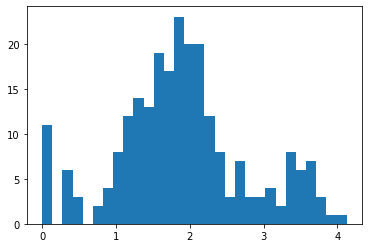

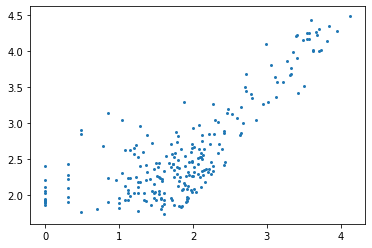

In [105]:
with loompy.connect('/proj/DEV_ATAC/Build_20220131/All/All_peaks.agg.loom') as  ds:
    print(ds.ca.keys())
    
    plt.hist(np.log10(ds.ca.Chemistry_multiome_atac + 1), bins=30)
    
    plt.figure()
    
    plt.scatter(np.log10(ds.ca.Chemistry_multiome_atac + 1),  np.log10(ds.ca.NCells +  1), marker='.', lw=0)

In [88]:
np.array(labels2)[order]

array(['Endo', 'Granule interneuron', 'GABA_prog', 'Purk_1', 'CN', 'GNP',
       'uRL', 'Mgl', 'Peri', 'OPC', 'Purk_2', 'RGL', 'CB neuroblast',
       'RP', 'VZ_prog', 'unannotated', 'Ery'], dtype='<U19')

In [87]:
order

array([ 2,  6,  4, 10,  1,  5, 15,  7,  9,  8, 11, 12,  0, 13, 14, 16,  3])

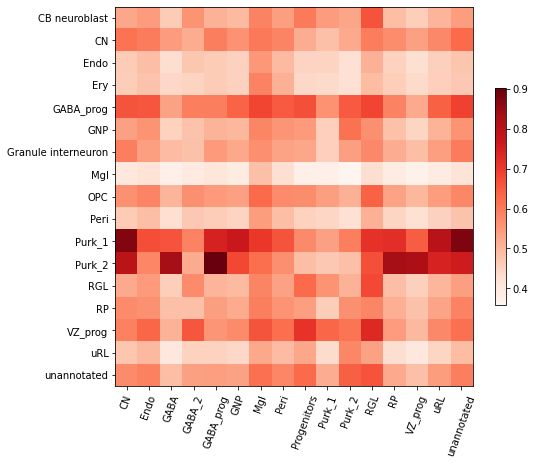

In [84]:
fdir1 = '/datb/sl/camiel/HARs/CB_Skene/Share_20220215/fixed/beds/'
fdir2 = '/datb/sl/camiel/HARs/CB_Skene/Share_20211015/beds/'

files1 = sorted(glob.glob(os.path.join(fdir1, '*.bed')))
files1.pop(0)
files2 = sorted(glob.glob(os.path.join(fdir2, '*.bed')))
files2.pop(0)
clusters1 = [x.split('/')[-1].split('.')[0] for x in files1]
clusters2 = [x.split('/')[-1].split('.')[0] for x in files2]

# X = np.zeros((len(files1), len(files2)))

# for i in range(len(files1)):
#     for j in range(len(files2)):
#         bd1 = BedTool(files1[i])
#         bd2 = BedTool(files2[j])

#         overlap = bd1.intersect(bd2).count()
#         total = bd1.cat(bd2).count()
        
#         X[i,j] = overlap/total

#         totals = [bd1.count(), bd2.count()]
#         X[i,j] = overlap/min(totals)
            
order = np.argmax(X, axis=1)  
fig, ax = plt.subplots(figsize=(8,8));
im  = ax.imshow(X, cmap='Reds');
plt.xticks(np.arange(len(clusters2)), clusters2, rotation=70);
plt.yticks(np.arange(len(clusters1)), clusters1);

plt.xt
fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)

In [89]:
for f in glob.glob('/datb/sl/camiel/HARs/CB_Skene/Share_20211015/beds/*.bed'):
    print(f.split('/')[-1], BedTool(f).count())

GABA_2.bed 29562
GABA.bed 29088
All_peaks.bed 465111
unannotated.bed 23021
GABA_prog.bed 22140
Endo.bed 25000
Peri.bed 25874
Mgl.bed 19776
RP.bed 28319
Purk_2.bed 36468
VZ_prog.bed 28539
Purk_1.bed 34244
uRL.bed 28253
GNP.bed 28919
Progenitors.bed 33913
CN.bed 22958
RGL.bed 26021


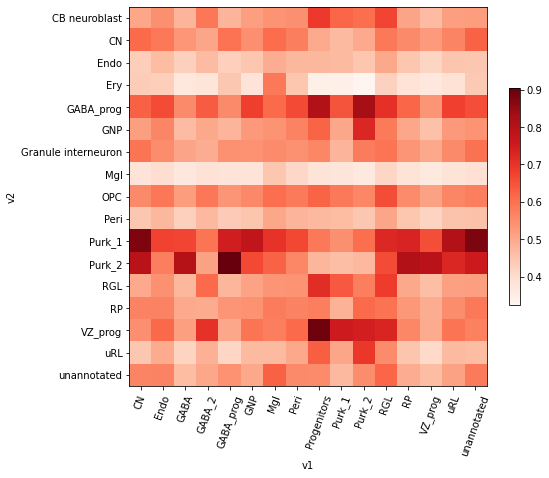

In [86]:
fdir1 = '/datb/sl/camiel/HARs/CB_Skene/Share_20220215/variable/beds/'
fdir2 = '/datb/sl/camiel/HARs/CB_Skene/Share_20211015/beds/'

files1 = sorted(glob.glob(os.path.join(fdir1, '*.bed')))
files1.pop(0)
files2 = sorted(glob.glob(os.path.join(fdir2, '*.bed')))
files2.pop(0)
clusters1 = [x.split('/')[-1].split('.')[0] for x in files1]
clusters2 = [x.split('/')[-1].split('.')[0] for x in files2]

X = np.zeros((len(files1), len(files2)))

for i in range(len(files1)):
    for j in range(len(files2)):
        bd1 = BedTool(files1[i])
        bd2 = BedTool(files2[j])

        overlap = bd1.intersect(bd2).count()
        total = bd1.cat(bd2).count()
        
        X[i,j] = overlap/total

#         totals = [bd1.count(), bd2.count()]
#         X[i,j] = overlap/min(totals)
            
fig, ax = plt.subplots(figsize=(8,8));
im  = ax.imshow(X, cmap='Reds');
plt.xlabel('v1')
plt.xticks(np.arange(len(clusters2)), clusters2, rotation=70);
plt.ylabel('v2')
plt.yticks(np.arange(len(clusters1)), clusters1);
fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)

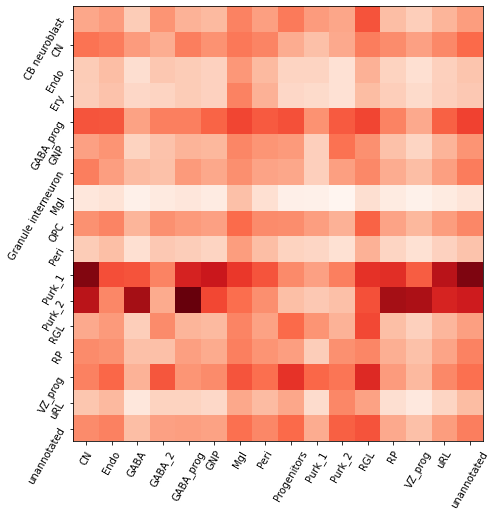

In [63]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(X, cmap='Reds')
ax.set_xticks(np.arange(X.shape[1]))
ax.set_xticklabels(clusters2,rotation=60);
ax.set_yticks(np.arange(X.shape[0]))
ax.set_yticklabels(clusters1,rotation=60);

In [47]:
order = np.argmax(X, axis=1)  
order = np.argsort(order)
plt.imshow(X[:,order])

IndexError: index 16 is out of bounds for axis 1 with size 16

In [2]:
#Imports
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import loompy
from typing import *
import multiprocessing as mp
import pybedtools
from pybedtools import BedTool
import multiprocessing as mp

from chromograph.pipeline import config
from chromograph.peak_analysis.utils import *

from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.manifold import GraphSkeletonizer
import cytograph.plotting as cgplot
from cytograph.plotting import manifold

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

def retrieve_enrichments(ds, motif_dir, N=5):
    '''
    Retrieved the top N motifs from Homer findMotifs results
    '''
    ld = os.listdir(motif_dir)
    c_dict = {}
    for d in ld:
        n = int(d.split('_')[-1])
        mat = np.loadtxt(os.path.join(motif_dir, d, 'knownResults.txt'), dtype=str, skiprows=1)
        c_dict[n] = ' '.join([x.split('_')[0] for x in mat[:N,0]])
    
    motif_markers = np.array([c_dict[x] for x in ds.ca.Class])
    return motif_markers

def KneeBinarization(dsagg: loompy.LoomConnection, bins: int = 200, mode: str = 'linear', bounds:tuple=(40,200)):
    '''
    Identifies positive peaks for every cluster based on the decay curve of the CPM values
    
    Args:
        ds          LoomConnection to aggregated peak file
        bins        Number of bins to fit CPM scores into. Defaults to 200. User lower number for small cell counts.
                    High values can cause rougher curves.
        mode        'linear' or 'log'. Determines if values are scaled before determining inflection point. In general
                    'log' is more lenient in feature selection.
    Returns:
        peaks       Numpy array of positive peaks
        CPM_thres   Thresholds used for peak binarization in cluster
    '''
    logging.info(f'Binarize clusters by knee point')
    ## Create layer
    peaks = np.zeros(dsagg.shape)
    CPM_thres = np.zeros(dsagg.shape[1])
    failed = []
    N_pos = []

    for i in range(dsagg.shape[1]):

        if mode == 'linear':
            vals = dsagg['CPM'][:,i]
            values, base = np.histogram(vals, bins = bins)
            cumulative = np.cumsum(values)

            x = base[:-1]
            y = len(vals)-cumulative

            kn = KneeLocator(x, y, curve='convex', direction='decreasing', interp_method='polynomial')
            t = kn.knee

            if (t > bounds[1]) or (t < bounds[0]):
                failed.append(i)

            else:
                CPM_thres[i] = t
                valid = vals > t
                N_pos.append(np.sum(valid))
                peaks[:,i] = valid


        elif mode == 'log':
            vals = np.log10(dsagg['CPM'][:,i]+1)
            values, base = np.histogram(vals, bins = bins)
            cumulative = np.cumsum(values)

            x = base[:-1]
            y = np.log10((len(vals)-cumulative)+1)

            kn = KneeLocator(x, y, curve='concave', direction='decreasing', interp_method='polynomial')
            t = 10**kn.knee
            
            if t > bounds[1]:
                failed.append(i)

            else:
                CPM_thres[i] = t
                valid = vals > np.log10(t)
                N_pos.append(np.sum(valid))
                peaks[:,i] = valid

        else:
            logging.info('No correct mode selected!')
            return
        
    ## Set threshold in accordance with mean number of positive features
    if len(failed) > 0:
        logging.info(f'failed to set threshold in {len(failed)} clusters')
        N_feat = np.mean(N_pos)
        for i in failed:
            vals = dsagg['CPM'][:,i]
            t = np.quantile(vals, 1-(N_feat/vals.shape[0]))
            CPM_thres[i] = t
            peaks[:,i] = vals > t

    return peaks, CPM_thres

class Peak_Aggregator:
    def __init__(self) -> None:
        '''
        Aggregate the Peak matrix
        '''
        self.config = config.load_config()

    def fit(self, ds: loompy.LoomConnection, out_file: str, agg_spec: Dict[str, str] = None) -> None:
        '''
        Aggregate the matrix, find markers and annotate enriched motifs by homer
        
        Args:
            ds              LoomConnection. Dataset must contain ds.ra.Gene and ds.ca.Clusters
            outfile         Filename of aggregation file
            agg_spec        Dictionary containing numpy-groupies function to be applied to column attributes
        '''
        self.outdir = '/' + os.path.join(*out_file.split('/')[:-1], 'exported')
        self.motifdir = '/' + os.path.join(*out_file.split('/')[:-1], 'motifs')

        agg_spec = {
            "Age": "mean",
            "Clusters": "tally",
            "Class": "first",
            "Class_labels": "first",
            "NPeaks": "mean",
            "Sex": "tally",
            "Tissue": "tally",
            "Chemistry": "tally",
            "SampleID": "tally",
            "TissuePool": "first",
            "Outliers": "mean",
            "PCW": "mean"
        }
        
        cells = ds.col_attrs["Class"] >= 0
        labels = ds.col_attrs["Class"][cells]
        n_labels = len(set(labels))

#         logging.info("Aggregating Classes")
#         ds.aggregate(out_file, None, "Class", "sum", agg_spec)
        with loompy.connect(out_file) as dsout:

            if n_labels <= 1:
                return

            logging.info('Calculate coverage metrics')
            dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
            dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]
            dsout.ca.NCells = np.bincount(labels, minlength=n_labels)
            
            dsout.permute(ordering=dsout.ca.Class.argsort(), axis=1)

            ## Normalize peak counts by total fragments per cluster
            logging.info('Convert to CPMs')
            dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

            ## Call positive and negative peaks for every cluster
            dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout, bounds=(5,40))

            ## Select markers by residuals
            markers = Enrichment_by_residuals(dsout)

            # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
            data = dsout[:, :][markers, :].T
            data[np.where(data<0)] = 0  ## BUG handling. Sometimes values surpass the bit limit in malignant cells
            data = np.log(data + 1)
            D = pdist(data, 'correlation')
            dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

            ## Run Homer findMotifs to find the top 5 motifs per cluster
            logging.info(f'Finding enriched motifs among marker peaks')
            
            if not os.path.isdir(self.motifdir):
                os.mkdir(self.motifdir) 

            piles = []
            for x in range(dsout.shape[1]):
                Valids = dsout.layers['marker_peaks'][:,x]
                bed_file = os.path.join(self.motifdir, f'Class_{x}.bed')
                peaks = BedTool([(dsout.ra['Chr'][x], str(dsout.ra['Start'][x]), str(dsout.ra['End'][x]), str(dsout.ra['ID'][x]), '.', '+') for x in np.where(Valids)[0]]).saveas(bed_file)
                piles.append([bed_file, os.path.join(self.motifdir, f'Cluster_{x}')])

            for pile in piles:
                Homer_find_motifs(bed=pile[0], outdir=pile[1], homer_path=self.config.paths.HOMER, motifs=os.path.join(chromograph.__path__[0], 'references/human_TFs.motifs'), cpus=mp.cpu_count())

            dsout.ca.Enriched_Motifs = retrieve_enrichments(dsout, self.motifdir, N=self.config.params.N_most_enriched)

            # logging.info("Graph skeletonization")
            GraphSkeletonizer(min_pct=1).abstract(ds, dsout)

            ## Plot results 
            name = out_file.split('/')[-1].split('_')[0]
            if 'UMAP' in ds.ca:
                logging.info("Plotting UMAP")
                manifold(ds, os.path.join(self.outdir, f"{name}_peaks_UMAP.png"), list(dsout.ca.Enriched_Motifs), embedding = 'UMAP')
            logging.info("Plotting TSNE")
            manifold(ds, os.path.join(self.outdir, f"{name}_peaks_TSNE.png"), list(dsout.ca.Enriched_Motifs), embedding = 'TSNE')

            ## Plotting neighborhoods and metromap
            cgplot.radius_characteristics(ds, os.path.join(self.outdir, f"{name}_neighborhouds.png"))
            cgplot.metromap(ds, dsout, os.path.join(self.outdir, f"{name}_metromap.png"), embedding = 'TSNE')

            return

# f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
# f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
        
# with loompy.connect(f) as ds:
#     PA = Peak_Aggregator()
#     PA.fit(ds, f_agg)

In [3]:
## Imports
import os
import sys
import collections
import loompy
from tqdm import tqdm
from typing import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

from collections import Counter
from pynndescent import NNDescent

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.pipeline import config
from chromograph.RNA.utils import *
from chromograph.plotting.sample_distribution_plot import sample_distribution_plot

import cytograph as cg
import cytograph.plotting as cgplot
from cytograph.species import Species
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import Trinarizer

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

from typing import Tuple, List

import numpy as np

import loompy


class AutoAutoAnnotator:
	"""
	Automatically discover suitable auto-annotation marker combinations
	"""
	def __init__(self, pep: float = 0.05, n_genes: int = 6, genes_allowed: np.ndarray = None) -> None:
		self.pep = pep
		self.n_genes = max(2, n_genes)
		self.genes_allowed = genes_allowed
	
	def fit(self, dsagg: loompy.LoomConnection) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
		"""
		Find highly specific and robust auto-annotation gene sets for all clusters in the file
		Returns:
			selected		The selected genes (indexes into the rows), shape (n_genes, n_clusters)
			selectivity		The cumulative selectivity (number of clusters identified), shape (n_genes, n_clusters)
			specificity		The cumulative specificity (difference in probabililty of identifying the cluster,
							relative to the second likeliest cluster), shape (n_genes, n_clusters)
			robustness		The cumulative robustness (probability of identifying the cluster), shape (n_genes, n_clusters)
		"""
		blocked = np.in1d(dsagg.ra.Gene, ['Xist', 'Tsix', 'Junb', 'Fos', 'Egr1', 'Jun']).nonzero()[0]

		trinaries = dsagg.layer["trinaries"][:, :]
		enrichment = dsagg.layer["enrichment"][:, :]
		n_clusters = dsagg.shape[1]
		positives = (trinaries > (1 - self.pep)).astype('int')
		genes = np.where(np.logical_and(positives.sum(axis=1) < n_clusters * 0.5, positives.sum(axis=1) > 0))[0]
		if self.genes_allowed is not None:
			genes = np.intersect1d(genes, self.genes_allowed)
	
		# Select the most enriched gene in each cluster
		gene1 = []  # type: List[int]
		for ix in range(dsagg.shape[1]):
			candidates = np.where(positives[:, ix] == 1)[0]
			candidates = np.setdiff1d(candidates, blocked)
			ordering = np.argsort(-enrichment[candidates, ix])
			try:
				gene1.append(candidates[ordering][0])
			except IndexError:
				gene1.append(0)  # NOTE NOTE NOTE very bad patch but I want to make it run to the end
		selected = np.array(gene1)[None, :]

		# Select the most enriched most specific gene for each cluster, given genes previously selected
		for _ in range(self.n_genes - 1):
			gene2 = []
			for ix in range(dsagg.shape[1]):
				# For each gene, the number of clusters where it's positive, shape (n_genes)
				breadth = (positives * np.prod(positives[selected[:, ix]], axis=0)).sum(axis=1)
				# The genes that are expressed in cluster ix, excluding previously selected and blocked genes
				candidates = np.where(positives[:, ix] == 1)[0]
				candidates = np.setdiff1d(candidates, selected)
				candidates = np.setdiff1d(candidates, blocked)
				try:
					# Now select the most specific gene, ranked by enrichment
					narrowest = breadth[candidates][breadth[candidates].nonzero()].min()
					candidates = np.intersect1d(candidates, np.where(breadth == narrowest)[0])
					ordering = np.argsort(-enrichment[candidates, ix])
					gene2.append(candidates[ordering][0])
				except (IndexError, ValueError):
					gene2.append(0)  # NOTE NOTE NOTE very bad patch but I want to make it run to the end
			gene2 = np.array(gene2)
			selected = np.vstack([selected, gene2])

		selectivity = np.cumprod(positives[selected], axis=0).sum(axis=1)
		robustness = np.array([np.cumprod(trinaries[selected[:, ix], ix]) for ix in np.arange(n_clusters)]).T

		specificity = []
		for c in np.arange(n_clusters):
			a = np.cumprod(trinaries[selected[:, :], c], axis=0)
			vals = []
			for ix in np.arange(5):
				temp = np.sort(a[ix, :])[-2:]
				vals.append(temp[-1] - temp[-2])
			specificity.append(vals)
		specificity = np.array(specificity).T

		return (selected, selectivity, specificity, robustness)

	def annotate(self, ds: loompy.LoomConnection) -> None:
		"""
		Annotate the loom file with marker gene sets based on auto-auto-annotation
		Remarks:
			Creates the following column attributes:
				MarkerGenes			Space-separated list of six marker genes
				MarkerSelectivity	Space-separated list of cumulative selectivity
				MarkerSpecificity	Space-separated list of cumulative specificity
				MarkerRobustness	Space-separated list of cumulative robustness
			
			See the fit() method for definitions of the metrics
		"""
		(selected, selectivity, specificity, robustness) = self.fit(ds)
		n_clusters = ds.shape[1]
		ds.ca.MarkerGenes = [" ".join(ds.ra.Gene[selected[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerSelectivity = [" ".join([str(x) for x in selectivity[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerSpecificity = [" ".join([f"{x:.2}" for x in specificity[:, ix]]) for ix in np.arange(n_clusters)]
		ds.ca.MarkerRobustness = [" ".join([f"{x:.2}" for x in robustness[:, ix]]) for ix in np.arange(n_clusters)]

class RNA_analysis():
    def __init__(self, ds, outdir):
        '''
        '''
        self.peak_file = ds.filename
        self.name = ds.filename.split('/')[-2]
        self.RNA_file = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA.loom')
        self.RNA_agg = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA.agg.loom')
        self.Imputed_file = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_RNA_imputed.loom')
        self.peak_agg = '/' + os.path.join(*ds.filename.split('/')[:-1], f'{self.name}_peaks.agg.loom')
        self.config = config.load_config()
        self.outdir = os.path.join(outdir, 'exported')
        
    def generate_RNA_file(self, RNA_files_dir):
        '''
        '''
        
        with loompy.connect(self.peak_file) as ds:
            samples = np.unique(ds.ca.Name[np.where(ds.ca.Chemistry == 'multiome_atac')[0]])
            inputfiles = [os.path.join(RNA_files_dir, f"{sample}.loom") for sample in samples]

            selections = []
            for sample, file in zip(samples, inputfiles):
                valid_cells = set(ds.ca.CellID)
                ## Get cells passing filters
                with loompy.connect(file, 'r') as ds2:
                    barcodes = rna_barcodes_to_atac(ds2)
                    if len(ds.ca.CellID[0].split('/')[-1].split('-')) > 1:
                        barcodes = [x + '-1' for x in barcodes]
                    good_cells = np.array([x in valid_cells for x in barcodes])
                    selections.append(good_cells)

            if os.path.isfile(self.RNA_file):
                os.remove(self.RNA_file)
            logging.info(f'Combining files')
            loompy.combine_faster(inputfiles, self.RNA_file, selections=selections, key='Accession')

            ## transcribe cell IDs
            with loompy.connect(self.RNA_file) as dsout:
                dsout.ca.RNA_IDs = dsout.ca.CellID
                dsout.ca.CellID = rna_barcodes_to_atac(dsout)

                match = {k:v for v, k in enumerate(ds.ca.CellID)}
                if len(ds.ca['CellID'][0].split('-'))> 1:
                    new_order = np.array([match[x + '-1'] for x in dsout.ca['CellID']])
                else:
                    new_order = np.array([match[x] for x in dsout.ca['CellID']])

                for k in ds.ca:
                    if k != 'CellID':
                        dsout.ca[k] = ds.ca[k][new_order]
                
                if self.name == 'All':
                    logging.info(f'Plotting sample distribution')
                    sample_distribution_plot(dsout, os.path.join(self.outdir, f"{self.name}_RNA_cell_counts.png"))
            logging.info(f'Finished creating file')  
        
    def Impute_RNA(self):
        '''
        '''
        
        if not os.path.isfile(self.RNA_file):
            logging.info(f'Generate the merged RNA file first!')
            return
        
        logging.info(f'Imputing RNA layer')
        
        ## Generate Imputation file
        if os.path.isfile(self.Imputed_file):
            os.remove(self.Imputed_file)

        with loompy.connect(self.peak_file) as ds:
            with loompy.connect(self.RNA_file) as dsr:
                RNA_barcodes = set(dsr.ca.CellID)
                x = np.array([x not in RNA_barcodes for x in ds.ca.CellID])
                cells = np.where(x)[0]
                M = dsr.shape[0]
                N = ds.shape[1]

                RNA_barcodes = set(dsr.ca.CellID)

                if len(ds.ca['CellID'][0].split('-'))> 1:
                    x = [x.split('-')[0] not in RNA_barcodes for x in ds.ca.CellID]
                    new_barcodes = ds.ca.CellID[x]
                    rna_bars = [x + '-1' for x in dsr.ca.CellID]
                    all_barcodes = np.concatenate([rna_bars, new_barcodes])
                else:
                    x = [x not in RNA_barcodes for x in ds.ca.CellID]
                    new_barcodes = ds.ca.CellID[x]
                    all_barcodes = np.concatenate([dsr.ca.CellID, new_barcodes])

                if ds.shape[1] > 10000:
                    batch = 1024
                    M = dsr.shape[0]
                    N = batch
                    empty_mat = sparse.csr_matrix((M,N), dtype=dsr[''].dtype)
                    cols = {'CellID': all_barcodes[:batch]}
                    logging.info(f'Create file')
                    loompy.create(self.Imputed_file, empty_mat, dsr.ra, cols)

                    with loompy.connect(self.Imputed_file) as dsout:
                        n_iter = np.ceil(ds.shape[1] / batch).astype(int)

                        pbar = tqdm(len(all_barcodes))
                        for i in range(1,n_iter):
                            start = i * batch
                            end = (i+1) * batch
                            if end > ds.shape[1]:
                                end = ds.shape[1]

                            N = end - start
                            empty_mat = np.zeros((M,N), dtype=dsr[''].dtype)
                            dsout.add_columns({'': empty_mat}, col_attrs={'CellID': all_barcodes[start:end]}, row_attrs=ds.ra)
                            pbar.update(batch)
                        pbar.close()
                 
                else:
                    empty_mat = sparse.csr_matrix((M,N), dtype=dsr[''].dtype)
                    logging.info(f'Creating file')
                    loompy.create(self.Imputed_file, empty_mat, dsr.ra, {'CellID': all_barcodes})

                with loompy.connect(self.Imputed_file) as dsi:
                    logging.info(dsi.shape)

                    ## Tranfer RNA data
                    for layer in dsr.layers:
                        if layer not in dsi.layers:
                            dsi[layer] = "uint16"
                        s = dsr[layer].shape
                        dsi[layer][:,:s[1]] = dsr[layer][:,:]

                    ## Transfer column attributes
                    logging.info(f'Transfer attributes')
                    transfer_ca(ds, dsi, 'CellID')

        with loompy.connect(self.RNA_file) as dsr:
            with loompy.connect(self.Imputed_file) as dsi:

                anchors = np.where(dsi.ca.Chemistry=='multiome_atac')[0]
                id_to_anchor = {i: a for i,a in enumerate(anchors)}
                queries = np.where(dsi.ca.Chemistry!='multiome_atac')[0]
                id_to_query = {i: a for i,a in enumerate(queries)}

                index = NNDescent(dsi.ca.LSI[anchors])

                X = index.query(dsi.ca.LSI[queries],10)

                data = X[1]
                max_d = np.max(data)
                data = (max_d - data) / max_d

                new_pos = []
                new_origin = []
                for i, row in enumerate(X[0]):
                    new_pos.append([id_to_anchor[x] for x in row])
                    new_origin.append([id_to_query[i] for x in range(len(row))])
                new_pos = np.array(new_pos)   
                new_origin = np.array(new_origin)

                nn = sparse.csr_matrix((data.flatten(), (new_origin.flatten(),new_pos.flatten())), shape=(dsi.shape[1],dsi.shape[1]), dtype='float')
                nn.eliminate_zeros()
                nn[anchors,anchors] = 1
                dsi.col_graphs['anchor_net'] = nn

                total_link = np.asarray(div0(1, np.sum(nn, axis=1))).reshape(-1)                    
                sources, targets = nn.nonzero()
                r = np.array([total_link[x] for x in sources])
                v = nn.data.flatten() * r
                scaled = sparse.csr_matrix((v, (sources,targets)), shape=nn.shape, dtype='float')

                logging.info(f'Pooling')
                dsi["pooled"] = 'int32'
                progress = tqdm(total = dsi.shape[0])
                if "spliced" in dsi.layers:
                    dsi["spliced_pooled"] = 'int32'
                    dsi["unspliced_pooled"] = 'int32'
                    for (_, indexes, view) in dsi.scan(axis=0, layers=["spliced", "unspliced"], what=["layers"]):
                        X = view.layers["spliced"][:, :] @ scaled.T
                        dsi["spliced_pooled"][indexes.min(): indexes.max() + 1, :] = view.layers["spliced"][:, :] @ scaled.T
                        dsi["unspliced_pooled"][indexes.min(): indexes.max() + 1, :] = view.layers["unspliced"][:, :] @ scaled.T
                        dsi["pooled"][indexes.min(): indexes.max() + 1, :] = dsi["spliced_pooled"][indexes.min(): indexes.max() + 1, :] + dsi["unspliced_pooled"][indexes.min(): indexes.max() + 1, :]
                        progress.update(512)
                else:
                    for (_, indexes, view) in dsi.scan(axis=0, layers=[""], what=["layers"]):
                        dsi["pooled"][indexes.min(): indexes.max() + 1, :] = view[:, :] @ scaled.T
                        
                progress.close()

                logging.info(f"Inferring cell cycle")
                species = Species.detect(dsi)
                CellCycleAnnotator(species).annotate(dsi, layer='pooled')
                cgplot.cell_cycle(dsi, os.path.join(self.outdir, self.name + "_cellcycle.png"))

    def annotate(self, min_cells:int=10, agg_spec=None, agg_label:str='Clusters'):
        '''
        '''
        if agg_spec == None:
            agg_spec = {
            "Age": "mean",
            "Clusters": "first",
            "Class": "first",
            "Total": "mean",
            "Sex": "tally",
            "Tissue": "tally",
            "Chemistry": "tally",
            "SampleID": "tally",
            "TissuePool": "first",
            "Outliers": "mean",
            "PCW": "mean"
            }
        if not os.path.isfile(self.RNA_file):
            logging.info(f'Generate RNA file first!')
            return
            
        with loompy.connect(self.RNA_file) as ds:
            cells = ds.col_attrs[agg_label] >= 0
            labels = ds.col_attrs[agg_label][cells]
            n_labels = len(set(labels))

            logging.info(f'Aggregating file')
            ds.aggregate(self.RNA_agg, None, agg_label, "mean", agg_spec)

            with loompy.connect(self.RNA_agg) as dsout:
                dsout.ca.NCells = np.bincount(labels, minlength=n_labels)[dsout.ca[agg_label]]

                logging.info("Computing cluster gene enrichment scores")
                fe = FeatureSelectionByMultilevelEnrichment(labels_attr="Class", mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")))
                markers = fe.fit(ds)
                dsout.layers["enrichment"] = fe.enrichment

                # Renumber the clusters
                logging.info("Compute the dendrogram")
                # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
                data = np.log(dsout[:, :] + 1)[markers, :].T
                D = pdist(data, 'correlation')
                dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)

                # Reorder the genes, markers first, ordered by enrichment in clusters
                logging.info("Permuting rows")
                mask = np.zeros(ds.shape[0], dtype=bool)
                mask[markers] = True
                # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
                gene_order = np.zeros(ds.shape[0], dtype='int')
                gene_order[mask] = np.argmax(dsout.layer["enrichment"][mask, :], axis=1)
                gene_order[~mask] = np.argmax(dsout.layer["enrichment"][~mask, :], axis=1) + dsout.shape[1]
                gene_order = np.argsort(gene_order)
                ds.permute(gene_order, axis=0)
                dsout.permute(gene_order, axis=0)
        
                logging.info(f'Trinarizing')
                trinaries = Trinarizer(0.2).fit(ds)
                dsout['trinaries'] = trinaries[:,dsout.ca[agg_label]]

                logging.info(f'Annotating')
                AutoAnnotator(self.config.paths.autoannotation, ds=dsout).annotate(dsout)

                logging.info("Computing auto-auto-annotation")
                AutoAutoAnnotator(n_genes=6).annotate(dsout)        
                
                ## Remove undersampled clusters
                remove = dsout.ca.NCells < min_cells
                logging.info(f'Clusters with too few measurements: {dsout.ca[agg_label][remove]}')
                for k in ['AutoAnnotation', 'MarkerGenes', 'MarkerRobustness', 'MarkerSelectivity', 'MarkerSpecificity']:
                    new_attr = dsout.ca[k]
                    new_attr[remove] = ''
                    dsout.ca[k] = new_attr

        ## Export the labels to the peak_aggregate file
        logging.info(f'Tranferring labels to peak aggregate file')
        with loompy.connect(self.RNA_agg) as dsagg:
            with loompy.connect(self.peak_agg) as dsout:
                annot = np.repeat('', dsout.shape[1]).astype('U128')
                annot[dsagg.ca[agg_label]] = dsagg.ca.AutoAnnotation
                dsout.ca.AutoAnnotation = annot

                annot = np.repeat('', dsout.shape[1]).astype('U128')
                annot[dsagg.ca[agg_label]] = dsagg.ca.MarkerGenes
                dsout.ca.MarkerGenes = annot      
                
        with loompy.connect(self.peak_file) as ds:
            with loompy.connect(self.peak_agg) as dsagg:
                cgplot.manifold(ds, os.path.join(self.outdir, f"{self.name}_Annotations.png"), list(dsagg.ca.MarkerGenes), list(dsagg.ca.AutoAnnotation), embedding = 'TSNE')
                
# f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
# f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

# with loompy.connect(f, 'r') as ds:
#     RA = RNA_analysis(ds, '/datb/sl/camiel/HARs/CB_Skene/Cerebellum')
# RA.generate_RNA_file("/proj/loom")
# RA.annotate(agg_label='Class')

['', 'ambiguous', 'pooled', 'spliced', 'spliced_pooled', 'unspliced', 'unspliced_pooled']


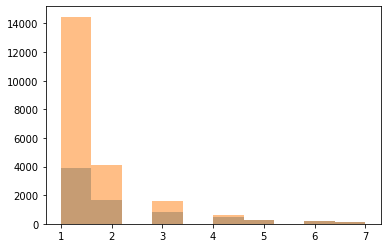

In [112]:
file = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.loom'

with loompy.connect(file) as ds:
    x = np.where(ds.ra.Gene=='PCP4')[0]
    print(ds.layers.keys())
    plt.hist(ds[x,:].flatten(), alpha=.5, range=(1,7));
    plt.hist(ds['pooled'][x,:].flatten(), alpha=.5, range=(1,7));

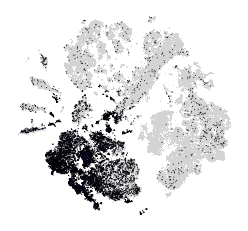

In [117]:
g = 'HES5'
with loompy.connect(file) as ds:
    v = ds['pooled'][np.where(ds.ra.Gene==g)[0],:].flatten()
    x = v > 0
    plt.scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=1, color='lightgray');
    plt.scatter(ds.ca.TSNE[x,0], ds.ca.TSNE[x,1], lw=0, s=1, c=v[x], cmap='magma');
    plt.axis('off')
    plt.gca().set_aspect('equal')

['BRC2237' 'BRC2256' 'BRC2260' 'BRC2269' 'BRC2289' 'H200476' 'HDBR15598'
 'HDBR15604' 'HDBR15777' 'XDD405' 'XDD415' 'XDD424']


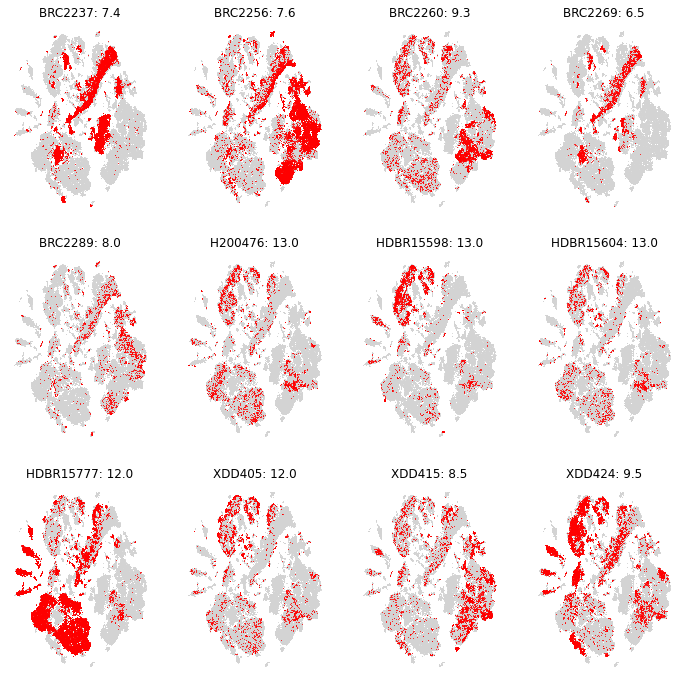

In [118]:
with loompy.connect(file) as ds:
    samples = np.unique(ds.ca.Shortname)
    print(samples)
    
    nrows = int(np.ceil(len(samples) / 4))
    fig, ax = plt.subplots(nrows,4, figsize=(12,12))
    ax = ax.flatten()
    
    for i, s in enumerate(samples):
        x = np.where(ds.ca.Shortname==s)[0]
        age = ds.ca.Age[x][0]
        ax[i].scatter(ds.ca.TSNE[:,0], ds.ca.TSNE[:,1], lw=0, s=1, color='lightgray');
        ax[i].scatter(ds.ca.TSNE[x,0], ds.ca.TSNE[x,1], lw=0, s=1, color='red');
        ax[i].set_title(f'{s}: {age}')
        
    for i in range(len(ax)):
        ax[i].axis('off')

In [ ]:
with loompy.connect(file) as ds:
    ds.layers['raw'] = "int64"
    for (ix, selection, view) in tqdm(ds.scan(axis=1)):
        ds['raw'][:,selection] = view[''][:,:]
        ds[''][:,selection] = view['pooled'][:,:]

108it [05:45,  3.11s/it]

In [ ]:
## Imports
import os
import sys
import collections
import loompy
from tqdm import tqdm
from typing import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

from collections import Counter
from pynndescent import NNDescent

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.pipeline import config
from chromograph.RNA.utils import *
from chromograph.plotting.sample_distribution_plot import sample_distribution_plot

import cytograph as cg
import cytograph.plotting as cgplot
from cytograph.species import Species
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species
from cytograph.annotation import AutoAnnotator, AutoAutoAnnotator
from cytograph.enrichment import Trinarizer

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')


config = config.load_config()

agg_spec = {
    "Age": "mean",
    "Clusters": "first",
    "Class": "mode",
    "Total": "mean",
    "Sex": "tally",
    "Tissue": "tally",
    "Chemistry": "tally",
    "SampleID": "tally",
    "TissuePool": "first",
    "Outliers": "mean",
    "PCW": "mean"
    }

file = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.loom'
outfile = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.agg.loom'
outdir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/'

with loompy.connect(file) as ds:
    cells = ds.col_attrs["Clusters"] >= 0
    labels = ds.col_attrs["Clusters"][cells]
    n_labels = len(set(labels))

    logging.info(f'Aggregating file')
    ds.aggregate(outfile, None, "Clusters", "mean", agg_spec, layer="pooled")
    with loompy.connect(outfile) as dsout:
        print(dsout.shape)
        dsout.ca.NCells = np.bincount(labels, minlength=n_labels)[dsout.ca.Clusters]

        logging.info("Computing cluster gene enrichment scores")
        fe = FeatureSelectionByMultilevelEnrichment(mask=Species.detect(ds).mask(dsout, ("cellcycle", "sex", "ieg", "mt")))
        markers = fe.fit(ds)
        dsout.layers["enrichment"] = fe.enrichment

        # Redo the Ward's linkage just to get a tree that corresponds with the new ordering
        logging.info(f'Computing dendrogram')
        data = np.log(dsout[:, :] + 1)[markers, :].T
        D = pdist(data, 'correlation')
        dsout.attrs.linkage = hc.linkage(D, 'ward', optimal_ordering=True)
        
        # Reorder the genes, markers first, ordered by enrichment in clusters
        logging.info("Permuting rows")
        mask = np.zeros(ds.shape[0], dtype=bool)
        mask[markers] = True
        # fetch enrichment from the aggregated file, so we get it already permuted on the column axis
        gene_order = np.zeros(ds.shape[0], dtype='int')
        gene_order[mask] = np.argmax(dsout.layer["enrichment"][np.where(mask)[0], :], axis=1)
        gene_order[~mask] = np.argmax(dsout.layer["enrichment"][np.where(~mask)[0], :], axis=1) + dsout.shape[1]
        gene_order = np.argsort(gene_order)
        ds.permute(gene_order, axis=0)
        dsout.permute(gene_order, axis=0)

        logging.info(f'Trinarizing')
        trinaries = Trinarizer(0.2).fit(ds)
        dsout['trinaries'] = trinaries[:,dsout.ca.Clusters]

        logging.info(f'Annotating')
        AutoAnnotator(config.paths.autoannotation, ds=dsout).annotate(dsout)

        logging.info("Computing auto-auto-annotation")
        AutoAutoAnnotator(n_genes=6).annotate(dsout)    
        cgplot.manifold(ds, os.path.join(outdir, f"Cerebellum_Annotations.png"), list(dsout.ca.MarkerGenes), list(dsout.ca.AutoAnnotation), embedding = 'TSNE')

(36601, 113470)


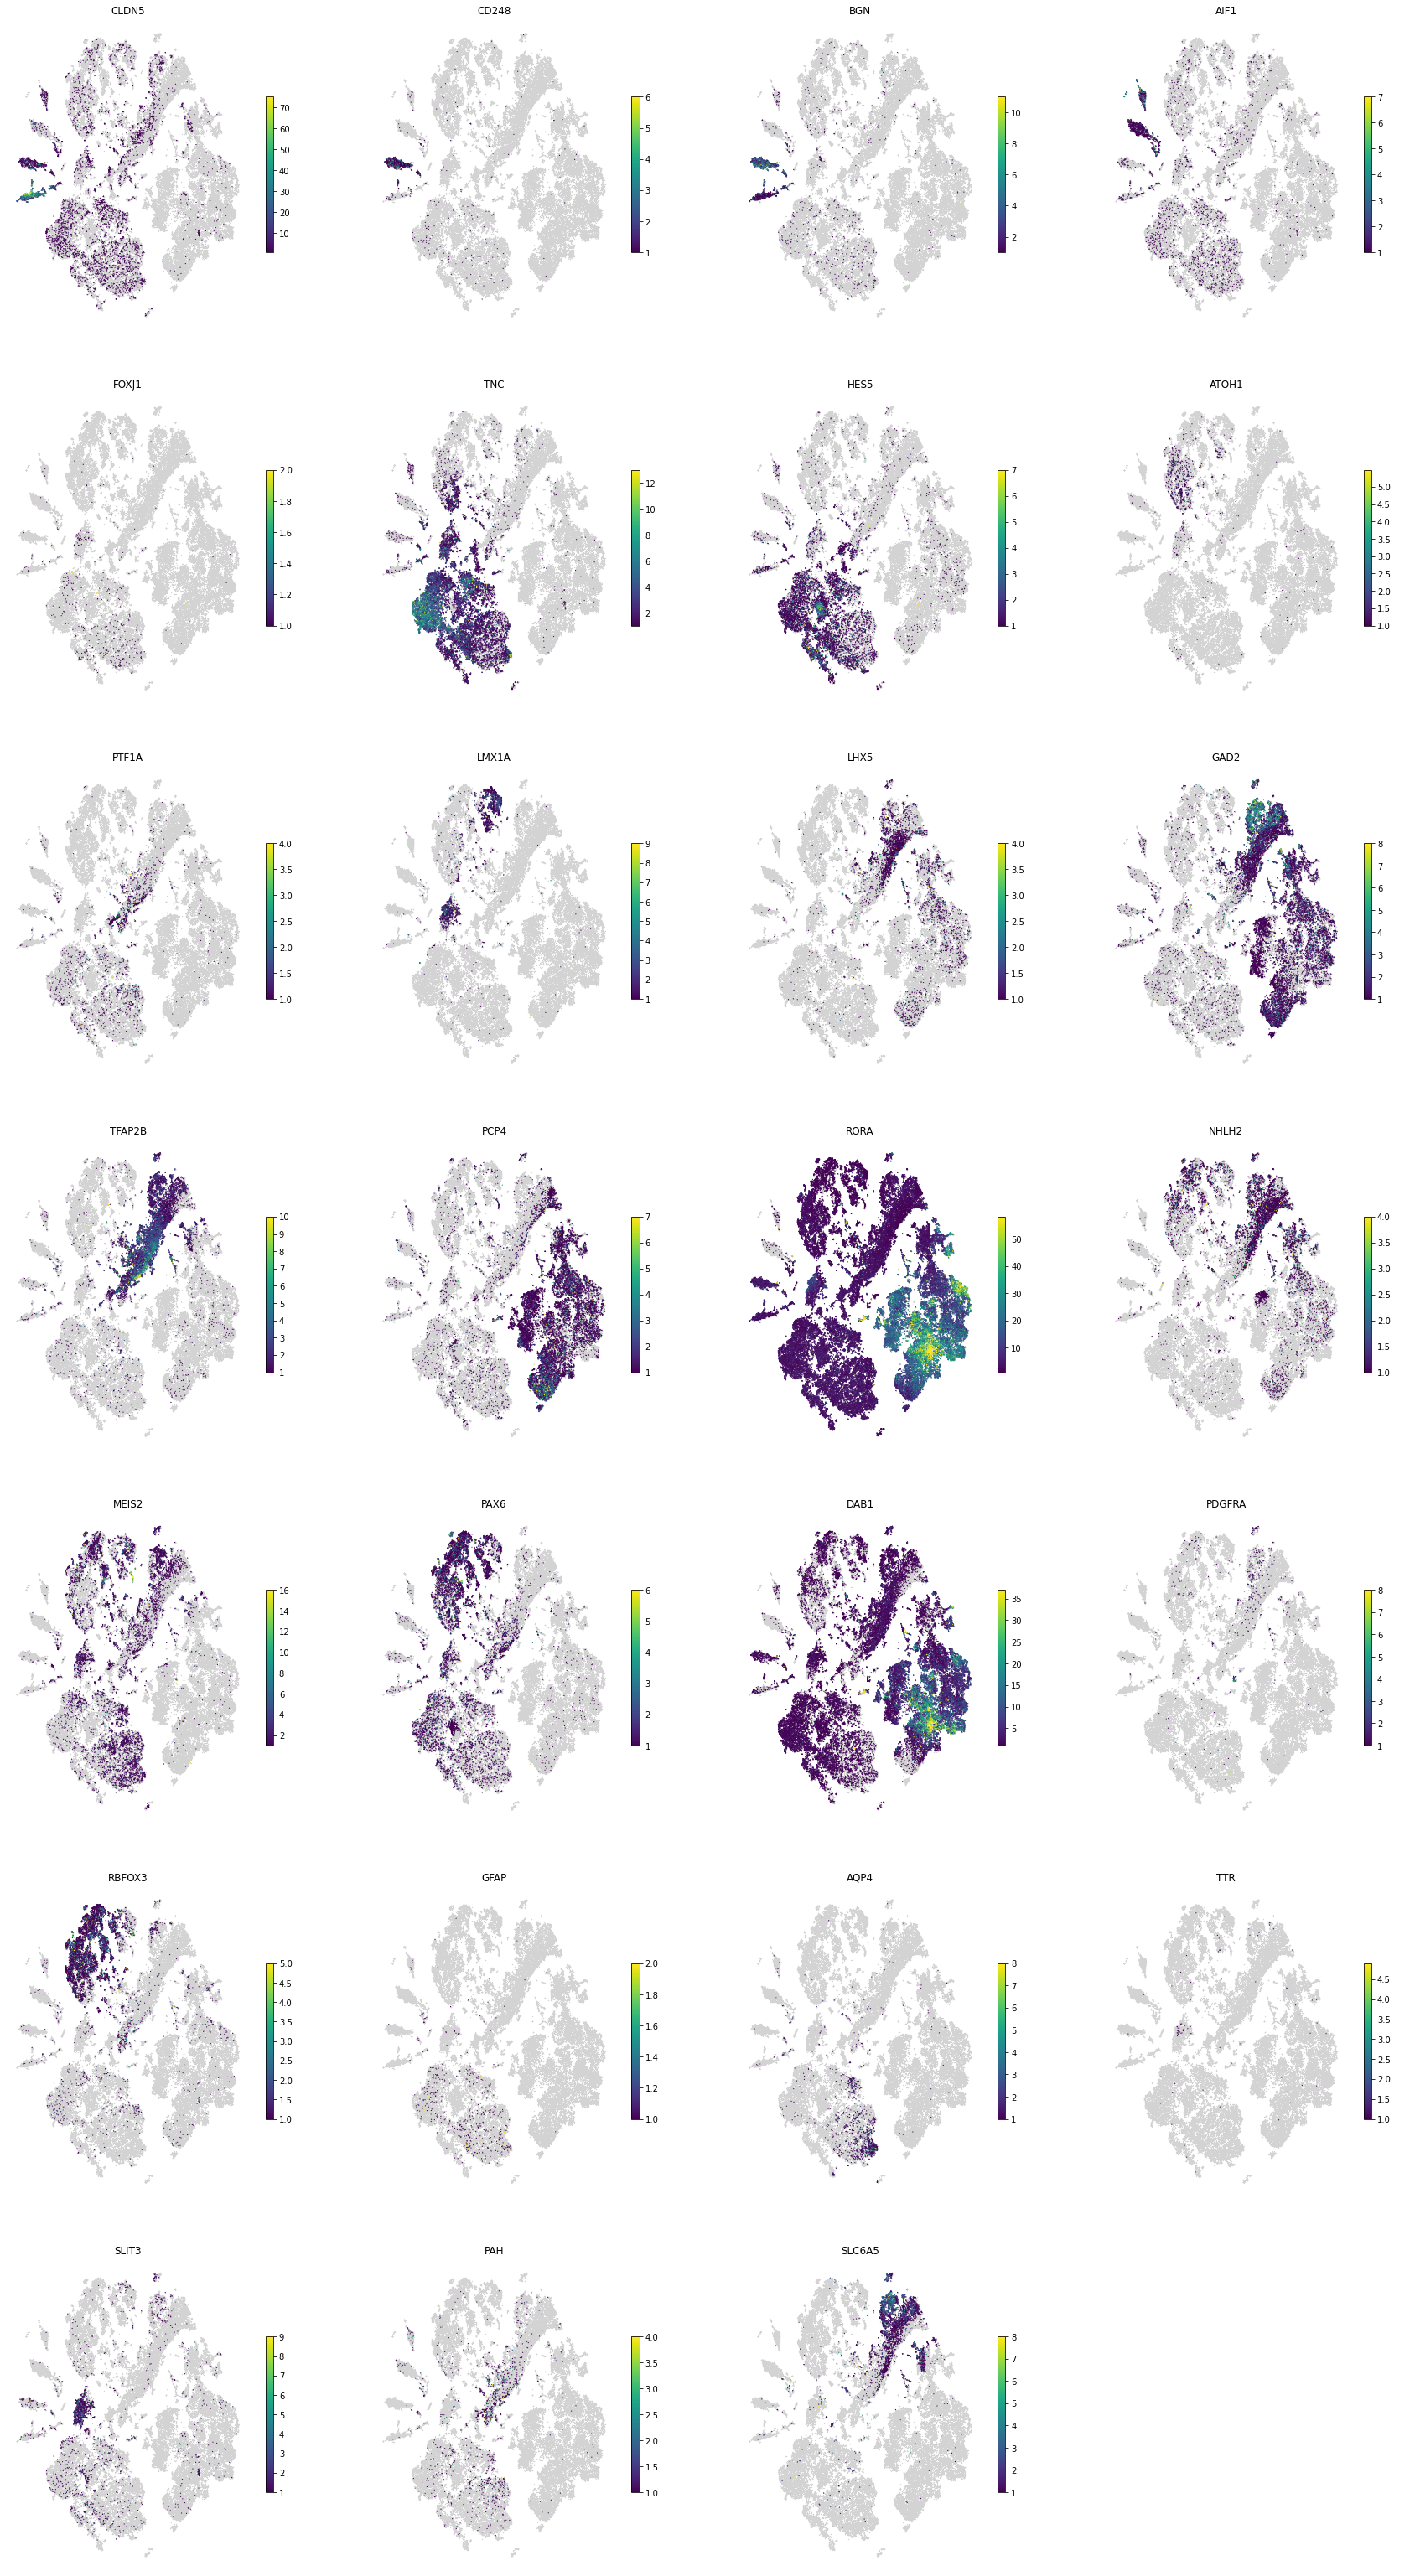

In [209]:
genes  =  ['CLDN5', # Endo
           'CD248', # Peri
           'BGN', # Meninges
           'AIF1', # Mgl
           'FOXJ1', # Ependymal
           'TNC', # RGL
           'HES5', # Progenitors
           'ATOH1', # uRL
           'PTF1A', # VZ
           'LMX1A', # Roof plate progenitors
           'LHX5', # GABA Prog
           'GAD2', # GABA
           'TFAP2B', # Intermediate (more detail needed)
           'PCP4', 'RORA', # Purkinje
           'NHLH2', # NBM CN
           'MEIS2', # GLU CN
           'PAX6', # Granule Neuron Progrenitor
           'DAB1', ## 
           'PDGFRA', # OPC
           'RBFOX3', # Neuron
           'GFAP', 'AQP4', # Astro
           'TTR', # Choroid Plexus
           'SLIT3',
           'PAH', # Hindbrain inh
           'SLC6A5' ## GLYT transporter
          ] 

nrows = int(np.ceil(len(genes)/4))
fig, ax = plt.subplots(nrows,4, figsize=(30,(nrows*8)))
ax = ax.flatten()

RNA_imp_f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.loom'
emb = 'TSNE'
with loompy.connect(RNA_imp_f, 'r') as ds:
    print(ds.shape)
    for i, gene in enumerate(genes):
        ## Inferred
        v = ds.layer['pooled'][ds.ra.Gene == gene,:].flatten()
        x = np.where(v > 0)[0]
        ax[i].scatter(ds.ca[emb][:,0], ds.ca[emb][:,1], c='lightgray', marker='.', lw=0, s=6)
        ax[i].set_title(gene)
        im = ax[i].scatter(ds.ca[emb][x,0], ds.ca[emb][x,1], c=v[x], cmap='viridis', vmax = np.quantile(v[x], .99), marker='.', lw=0, s=6)
        fig.colorbar(im, ax=ax[i], orientation='vertical', shrink=.5)
    
    for i in range(len(ax)):
        ax[i].axis('off')
    
        
    plt.savefig('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/Cerebellum_markers.png')

In [124]:
import cytograph.plotting as cgplot

f1 = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.loom'
f2 = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_RNA_clusters.agg.loom'
out_dir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/'

with loompy.connect(f1) as ds:
    with loompy.connect(f2) as dsagg:

        cgplot.markerheatmap(ds, dsagg, out_file=os.path.join(out_dir, "Cerebellum_clusters_RNA_pooled_heatmap.pdf"), layer="pooled")


['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellID', 'Chemistry', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Cmobarcodes', 'Comment', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FRIP', 'FRtss', 'GA_colsum', 'GA_pooled_colsum', 'Id', 'LSI', 'LSI_b', 'Label', 'Method', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'Plugdate', 'Project', 'PseudoAge', 'Roi', 'SEX', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Tissue', 'Transcriptome', 'UMAP', 'UMAP3D', 'UMAP3D_bin', 'UMAP_bin', 'Y', 'barcode', 'chimeric', 'duplicate', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'preClusters', 'total', 'unmapped']


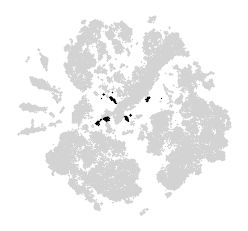

In [25]:
cls = missed
# cls = np.fromiter(range(81, 89), dtype=int)
# cls = classes['RGL']
cls = [49, 58, 59, 61, 64]
with loompy.connect('/proj/DEV_ATAC/Skene_20220208/All/All_peaks.loom') as ds:
    print(ds.ca.keys())
    plt.figure()
    x = np.where(np.isin(ds.ca.Clusters, cls))[0]
    plt.scatter(ds.ca['TSNE'][:,0], ds.ca['TSNE'][:,1], c='lightgray', marker='.', lw=0, s=6)
    plt.scatter(ds.ca['TSNE'][x,0], ds.ca['TSNE'][x,1], c='black', marker='.', lw=0, s=6)
    plt.axis('off')
    plt.gca().set_aspect('equal')

In [27]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

classes = {
'Endo': [73, 92, 93],
'Ery': [99],
'Peri': [72, 91],
'Mgl': [94, 95, 97, 96, 98],
'RGL': [46, 47, 48,  50, 51, 52, 53, 60, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88],
'uRL': [27, 56],
'VZ_prog': [49, 58, 59, 61, 63, 64],
'RP': [30, 31, 32],
'GABA_prog': [39, 54, 62],
'Granule interneuron': [38, 40],
'Purk_1': [13, 14, 17, 18, 19, 37],
'Purk_2': [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 16, 20, 21, 90],
'CB neuroblast': [89],
'CN': [44],
'GNP': [28, 29, 30, 33, 34, 35, 42, 43],
'unannotated': [22, 23, 24, 25, 26, 36, 41, 55, 57],
'OPC': [45]
}

cluster_to_class = {}

with loompy.connect(f) as ds:
    all_clusters = np.unique(ds.ca.Clusters)

included = np.unique([x for k, s in classes.items() for x in s])
missed = [x for x in all_clusters if x not in included]
print(missed)

for k in classes:
    for c in classes[k]:
        cluster_to_class[c] = k
        
with loompy.connect(f) as ds:
    ds.ca.Class_labels = np.array([cluster_to_class[x] for x in ds.ca.Clusters])
    d = {k:v for v, k in enumerate(np.unique(ds.ca.Class_labels))}
    ds.ca.Class = np.array([d[x] for x in ds.ca.Class_labels])
    logging.info(f'permute dataset')
    ds.permute(np.argsort(ds.col_attrs["Class"]), axis=1)  ## Order by class label

[]


10:15:44 INFO     permute dataset


In [28]:
with loompy.connect(f) as ds:
    print(np.unique(ds.ca.Class))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [ ]:
# f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum_20220131/Cerebellum_peaks.loom'

# # classes = {
# # 'Endo': [105, 106],
# # 'Ery': [33],
# # 'Peri': [107],
# # 'Mgl': [69, 74, 104],
# # 'RGL': [67, 68, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 98, 99, 100],
# # 'uRL': [35],
# # 'VZ_prog': [93],
# # 'RP': [50, 53],
# # 'GABA_prog1': [39, 41,42],
# # 'GABA_prog2': [28, 38, 40, 43],
# # 'Granule interneuron': [44, 45, 46, 46, 47, 48],
# # # 'GABA_2': 
# # 'Purkinje': np.fromiter(range(33),dtype=int),
# # # 'Purk_2': 
# # # 'GLUT_prog': 
# # 'CN': [37],
# # 'GNP': [34, 36, 49, 51, 52, 54, 55, 56, 57, 58, 59],
# # 'unannotated': [60, 61, 62, 63, 64, 65, 66, 70, 71, 94, 95, 96, 97, 101, 102, 103],
# # 'OPC': [92]
# # }

# cluster_to_class = {}

# with loompy.connect(f1) as ds:
#     all_clusters = np.unique(ds.ca.Clusters)

# included = np.unique([x for k, s in classes.items() for x in s])
# missed = [x for x in all_clusters if x not in included]
# print(missed)

# for k in classes:
#     for c in classes[k]:
#         cluster_to_class[c] = k
        
# with loompy.connect(f) as ds:
#     ds.ca.Class_labels = np.array([cluster_to_class[x] for x in ds.ca.Clusters])
#     d = {k:v for v, k in enumerate(np.unique(ds.ca.Class_labels))}
#     ds.ca.Class = np.array([d[x] for x in ds.ca.Class_labels])
#     logging.info(f'permute dataset')
#     ds.permute(np.argsort(ds.col_attrs["Class"]), axis=1)  ## Order by class label

In [ ]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

## Aggregate file        
with loompy.connect(f) as ds:
    PA = Peak_Aggregator()
    PA.fit(ds, f_agg)

16:45:38 INFO     Calculate coverage metrics
16:45:53 INFO     Convert to CPMs
16:45:55 INFO     Binarize clusters by knee point
16:46:07 INFO     Calculating residuals
16:46:10 INFO     Calculating fold change and selecting markers
16:47:03 INFO     Finding enriched motifs among marker peaks


In [8]:
outdir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/'
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

with loompy.connect(f, 'r') as ds:
    with loompy.connect(f_agg) as dsout:
        name = 'Cerebellum'
        manifold(ds, os.path.join(outdir, f"{name}_TSNE.png"), list(dsout.ca.Enriched_Motifs), embedding = 'TSNE', feature='Class')
        manifold(ds, os.path.join(outdir, f"{name}_UMAP.png"), list(dsout.ca.Enriched_Motifs), embedding = 'UMAP', feature='Class')

In [9]:
with loompy.connect(f, 'r+') as ds:
    print(ds.ca.keys())
    
    if not np.array_equal(ds.ca.Class, ds.ca.Clusters):
        print('.')
        ds.ca.Clusters_old = ds.ca.Clusters
        ds.ca.Clusters = ds.ca.Class

['Age', 'Agetext', 'Ageunit', 'All_fc_analysis_id', 'Analysis', 'CellID', 'Chemistry', 'Class', 'Class_labels', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Cmobarcodes', 'Comment', 'Datecaptured', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'FRIP', 'FRtss', 'GA_colsum', 'GA_pooled_colsum', 'Id', 'LSI', 'LSI_b', 'Label', 'Method', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'Plugdate', 'Project', 'PseudoAge', 'Roi', 'SEX', 'Sampleok', 'Sex', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Tissue', 'Transcriptome', 'UMAP', 'UMAP3D', 'UMAP3D_bin', 'UMAP_bin', 'Y', 'barcode', 'chimeric', 'duplicate', 'excluded_reason', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 'passed_filters', 'peak_region_cutsites', 'peak_region_fragments', 'preClusters', 'total', 'unmapped']
.


In [10]:
##  RNA analysis
with loompy.connect(f, 'r') as ds:
    RA = RNA_analysis(ds, '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/')
RA.generate_RNA_file("/proj/loom")
RA.annotate(agg_label='Class')

09:18:35 INFO     Combining files
09:22:22 INFO     Finished creating file
09:22:22 INFO     Aggregating file
09:23:07 INFO     Computing cluster gene enrichment scores
09:23:08 INFO     Multilevel marker selection with 17 clusters at the leaf level
09:23:08 INFO     Analyzing 2 higher levels with [5, 2] clusters
09:23:08 INFO     Computing enrichment statistic
09:23:46 INFO     Identifying valid genes
09:24:07 INFO     Found 170 marker genes at level 0 (leaves)
09:24:07 INFO     Computing enrichment statistic
09:24:40 INFO     Found 50 marker genes at level 1
09:24:40 INFO     Computing enrichment statistic
09:25:14 INFO     Found 20 marker genes at level 2
09:25:15 INFO     Compute the dendrogram
09:25:15 INFO     Permuting rows
09:27:28 INFO     Trinarizing
09:27:28 INFO     n_labels 17
09:30:15 INFO     Annotating
09:30:18 INFO     Computing auto-auto-annotation
09:30:18 INFO     Clusters with too few measurements: []
09:30:19 INFO     Tranferring labels to peak aggregate file


In [11]:
dx = {}
with loompy.connect(f, 'r') as ds:
    for i in np.unique(ds.ca.Class):
        label = ds.ca.Class_labels[ds.ca.Class==i][0]
        dx[i] = label

In [12]:
with loompy.connect(f_agg) as dsagg:
    dsagg.ca.Class_labels = np.array([dx[i] for i in dsagg.ca.Class])
    for i in range(dsagg.shape[1]):
        print(f'{dsagg.ca.Class_labels[i]}: {dsagg.ca.Enriched_Motifs[i]}')

CB neuroblast: NFIB.NFI/1.NFI TEAD4.TEAD.TEA RFX3.RFX/1.RFX OTX2.HD/19.homeodomain GSC.HD/20.homeodomain CRX.HD/20.homeodomain
CN: NEUROD1.Ebox/CAGATGG.bHLH NEUROD2.Ebox/CAGATGG.bHLH LBX2.HD/2.homeodomain NEUROG2.Ebox/CATATG.bHLH ATOH1.Ebox/CAGATGG.bHLH ZBTB49.ZBTB49.C2H2
Endo: ETV6.ETS/1.ETS ETV1.ETS/1.ETS ELK1.ETS/1.ETS ETV4.ETS/1.ETS ETV7.unclassified.unclassified ETS1.ETS/1.ETS
Ery: TAL1.GATA.C2H2 GATA1.GATA.C2H2 GATA6.GATA.C2H2 GATA4.GATA.C2H2 GATA2.GATA.C2H2 GATA3.GATA.C2H2
GABA_prog: TFAP2A.TFAP2/1.TFAP NEUROD1.Ebox/CAGATGG.bHLH ATOH1.Ebox/CAGATGG.bHLH NEUROG2.Ebox/CATATG.bHLH NEUROD2.Ebox/CAGATGG.bHLH TFAP2C.TFAP2/1.TFAP
GNP: NEUROD2.Ebox/CAGATGG.bHLH NEUROD1.Ebox/CAGATGG.bHLH ATOH1.Ebox/CAGATGG.bHLH MEIS3.MIES.MEIS NEUROG2.Ebox/CATATG.bHLH MEIS2.MIES.MEIS
Granule interneuron: NEUROD1.Ebox/CAGATGG.bHLH TFAP2A.TFAP2/1.TFAP ATOH1.Ebox/CAGATGG.bHLH NEUROD2.Ebox/CAGATGG.bHLH NEUROG2.Ebox/CATATG.bHLH PRRX2.HD/2.homeodomain
Mgl: SPI1.SPI.ETS SPIB.SPI.ETS EHF.ETS/1.ETS ELF3.ETS/1.ETS 

In [13]:
with loompy.connect(f, 'r') as ds:
    with loompy.connect(RA.RNA_agg) as dsout:
        name = 'Cerebellum'
        manifold(ds, os.path.join(outdir, f"{name}_TSNE.png"), embedding = 'TSNE', feature = 'Class')
        manifold(ds, os.path.join(outdir, f"{name}_UMAP.png"), embedding = 'UMAP', feature = 'Class')
        
        ## RNA
        manifold(ds, os.path.join(outdir, f"{name}_RNA_TSNE.png"), list(dsout.ca.MarkerGenes), list(dsout.ca.AutoAnnotation), embedding = 'TSNE', feature = 'Class')
        manifold(ds, os.path.join(outdir, f"{name}_RNA_UMAP.png"), list(dsout.ca.MarkerGenes), list(dsout.ca.AutoAnnotation), embedding = 'UMAP', feature = 'Class')

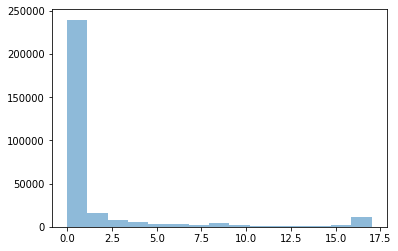

In [14]:
with loompy.connect(f_agg) as ds:
    N_clusters_active = ds['binary'].map([np.sum], axis=0)[0]
    plt.hist(N_clusters_active, bins=15, alpha=.5)

In [15]:
print(np.sum(N_clusters_active>0))
print(np.sum(N_clusters_active==1))
print(np.sum(N_clusters_active==15))

109396
46729
1636


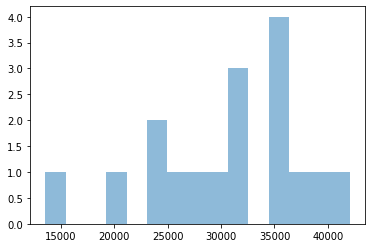

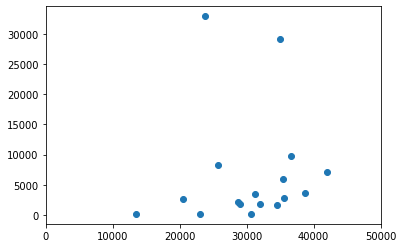

In [27]:
with loompy.connect(f_agg) as ds:
    N_peaks_active = ds['binary'].map([np.sum], axis=1)[0]
    plt.hist(N_peaks_active, bins=15, alpha=.5)

    plt.figure()
    plt.scatter(N_peaks_active, ds.ca.NCells)
    plt.xlim((0,50000))
    
#     for label, N in zip(ds.ca.Class_labels, N_peaks_active):
#         print(label, N)

In [36]:
Npeaks = 25000

with loompy.connect(f_agg) as ds:
    print(ds.shape)
    print(ds.layers.keys())
    ds['fixed_number_binary'] = 'int8'
    
    for i in range(ds.shape[1]):
        valid =  np.argsort(ds['CPM'][:,i])[-Npeaks:]
        x = np.zeros(ds.shape[0])
        x[valid] = 1
        ds['fixed_number_binary'][:,i] = x
        print(dx[i], np.min(ds['CPM'][:,i][np.where(x)[0]]))

(302136, 17)
['', 'CPM', 'binary', 'fixed_number_binary', 'log2fc', 'marker_peaks', 'residuals']
CB neuroblast 10.904619005851224
CN 10.023630709397404
Endo 10.713406177138491
Ery 5.1932472206390035
GABA_prog 10.5719673559255
GNP 10.386541892573954
Granule interneuron 10.185530344650155
Mgl 11.02090052813582
OPC 11.938922548575842
Peri 10.351472972257017
Purk_1 9.815706050220662
Purk_2 9.947254819610912
RGL 11.36035262689479
RP 10.199083714319105
VZ_prog 10.934413450380463
uRL 11.34311844883588
unannotated 9.322919902032327


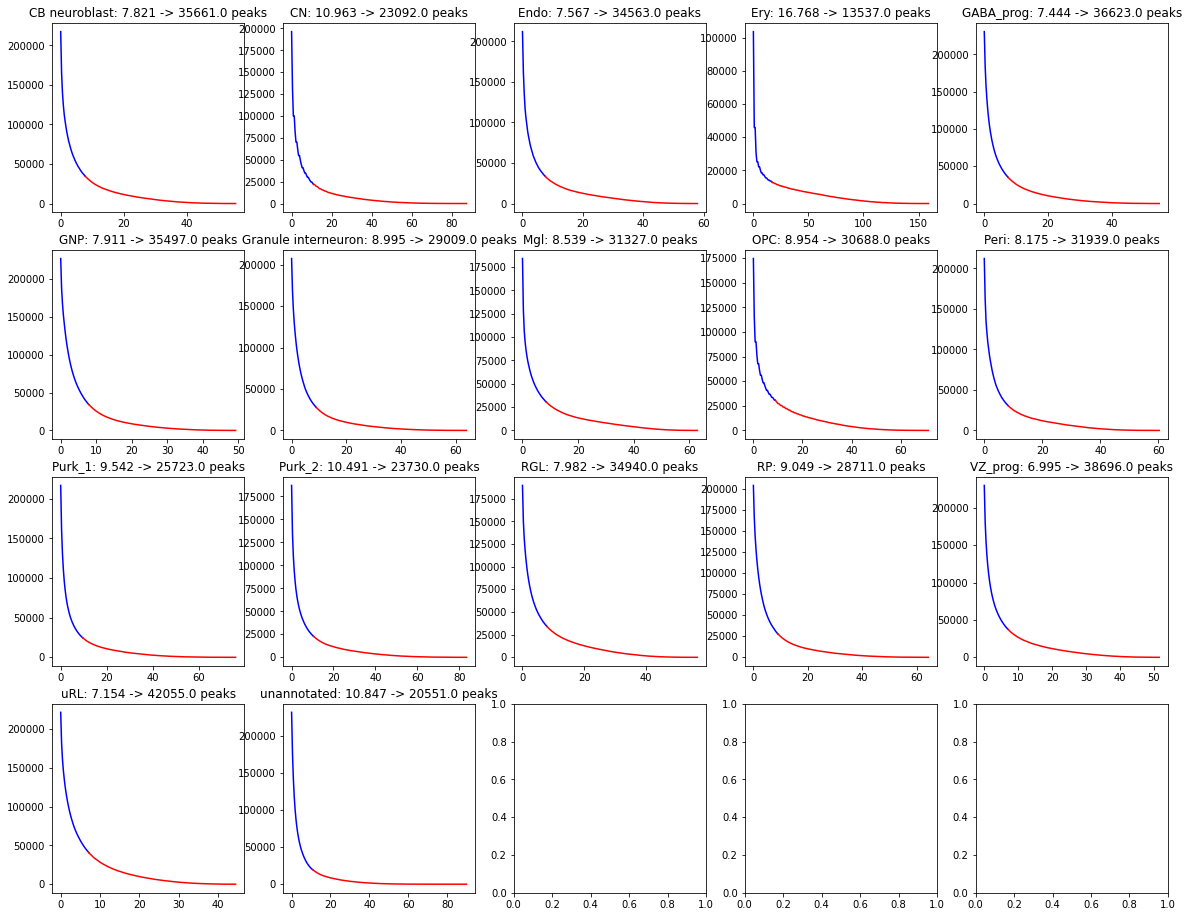

In [20]:
# class_to_label = {v:k for k,v in d.items()}
with loompy.connect(f_agg) as ds:

    fig, ax = plt.subplots(4,5, figsize=(20, 16))
    ax = ax.flatten()
    
    for i in range(ds.shape[1]):
        t = ds.ca.CPM_thres[i]
        
        vals = ds['CPM'][:,i]
        values, base = np.histogram(vals, bins = 200)
        cumulative = np.cumsum(values)

        x = base[:-1]
        y = len(vals)-cumulative
        
        ax[i].plot(x[x<=t],y[x<=t], c='blue')
        ax[i].plot(x[x>=t],y[x>=t], c='red')
        ax[i].set_title(f'{dx[ds.ca.Class[i]]}: {np.round(t, 3)} -> {N_peaks_active[i]} peaks')


In [51]:
from pybedtools import BedTool

f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
vardir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/variable'
outdir = os.path.join(vardir, 'beds')
outdir_bedgraph = os.path.join(vardir, 'beds_pileup')

if not os.path.isdir(vardir):
    os.mkdir(vardir)

with loompy.connect(f_agg) as ds:
    
    for x in [outdir, outdir_bedgraph]:
        if not os.path.exists(x):
            os.mkdir(x)
        
    for i in range(ds.shape[1]):
        cell_type = dx[ds.ca.Class[i]]
        print(cell_type)
        x = np.where(ds['binary'][:,i])[0]
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'name': ds.ra.ID[x], 'CPM': ds['CPM'][:,i][x], 'residuals': ds['residuals'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'{cell_type}.bed'))
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'CPM': ds['CPM'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir_bedgraph, f'{cell_type}.bedgraph'))        

    N_clusters_active = ds['binary'].map([np.sum], axis=0)[0]
    df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr, 'chromStart': ds.ra.Start, 'chromEnd': ds.ra.End, 'name': ds.ra.ID, 'N_clusters': N_clusters_active})
    BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'All_peaks.bed'))

CB neuroblast
CN
Endo
Ery
GABA_prog
GNP
Granule interneuron
Mgl
OPC
Peri
Purk_1
Purk_2
RGL
RP
VZ_prog
uRL
unannotated


In [52]:
from pybedtools import BedTool

f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'
fixdir = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/fixed'
outdir = os.path.join(fixdir, 'beds')
outdir_bedgraph = os.path.join(fixdir, 'beds_pileup')

if not os.path.isdir(fixdir):
    os.mkdir(fixdir)

with loompy.connect(f_agg) as ds:
    
    for x in [outdir, outdir_bedgraph]:
        if not os.path.exists(x):
            os.mkdir(x)
        
    for i in range(ds.shape[1]):
        cell_type = dx[ds.ca.Class[i]]
        print(cell_type)
        x = np.where(ds['fixed_number_binary'][:,i])[0]
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'name': ds.ra.ID[x], 'CPM': ds['CPM'][:,i][x], 'residuals': ds['residuals'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'{cell_type}.bed'))
        
        df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr[x], 'chromStart': ds.ra.Start[x], 'chromEnd': ds.ra.End[x], 'CPM': ds['CPM'][:,i][x]})
        BedTool.from_dataframe(df).saveas(os.path.join(outdir_bedgraph, f'{cell_type}.bedgraph'))        
        
    N_clusters_active = ds['fixed_number_binary'].map([np.sum], axis=0)[0]
    df = pd.DataFrame.from_dict({'chrom': ds.ra.Chr, 'chromStart': ds.ra.Start, 'chromEnd': ds.ra.End, 'name': ds.ra.ID, 'N_clusters': N_clusters_active})
    BedTool.from_dataframe(df).saveas(os.path.join(outdir, f'All_peaks.bed'))

CB neuroblast
CN
Endo
Ery
GABA_prog
GNP
Granule interneuron
Mgl
OPC
Peri
Purk_1
Purk_2
RGL
RP
VZ_prog
uRL
unannotated


In [43]:
with loompy.connect(f_agg) as ds:
#     keys = ['Age', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Class', 'Enriched_Motifs', 'MarkerGenes', 'NCells', 'NPeaks', 'Sex_', 'Total']
    keys = ['Age', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1_1', 'Class', 'Enriched_Motifs', 'MarkerGenes', 'NCells', 'NPeaks', 'Sex_', 'Total']
    d = {k: ds.ca[k] for k in keys}
    d['Class_labels'] = [dx[x] for x in ds.ca.Class]
    df = pd.DataFrame.from_dict(d)
    df.to_csv(os.path.join('/datb/sl/camiel/HARs/CB_Skene/Cerebellum', 'meta_data.csv'))
df

,Age,CPM_thres,Chemistry_multiome_atac,Chemistry_v1_1,Class,Enriched_Motifs,MarkerGenes,NCells,NPeaks,Sex_,Total,Class_labels
0,9.802806,7.820576,1147,1597,0,NFIB.NFI/1.NFI TEAD4.TEAD.TEA RFX3.RFX/1.RFX O...,SLIT3 LMX1A AC092958.4 ANGPT1 RSPO2 OTX2,2744,12786.995627,2744,35122731.0,CB neuroblast
1,7.782873,10.963346,81,100,1,NEUROD1.Ebox/CAGATGG.bHLH NEUROD2.Ebox/CAGATGG...,IL1RAPL2 LHX9 SLC17A6 AC117461.1 SNTG1 VWDE,181,8811.607735,181,1596228.0,CN
2,11.595923,7.567435,923,745,2,ETV6.ETS/1.ETS ETV1.ETS/1.ETS ELK1.ETS/1.ETS E...,FLT1 KDR CGNL1 ADGRL4 ERG CD93,1668,13026.997002,1668,21748452.0,Endo
3,10.114620,16.767697,59,112,3,TAL1.GATA.C2H2 GATA1.GATA.C2H2 GATA6.GATA.C2H2...,SLC4A1 SPTA1 HEMGN EPB42 HBM AHSP,171,4485.847953,171,770231.0,Ery
4,8.930432,7.444440,2321,7501,4,TFAP2A.TFAP2/1.TFAP NEUROD1.Ebox/CAGATGG.bHLH ...,TFAP2B ZBTB16 PRDM13 ROBO3 ST18 EBF2,9822,13210.084708,9822,129587990.0,GABA_prog
5,10.080087,7.911155,1164,4832,5,NEUROD2.Ebox/CAGATGG.bHLH NEUROD1.Ebox/CAGATGG...,CPNE4 ERVMER61-1 AC096570.1 KCNC2 FSTL4 LINC01697,5996,15372.386258,5996,92042184.0,GNP
6,10.232295,8.995096,522,1212,6,NEUROD1.Ebox/CAGATGG.bHLH TFAP2A.TFAP2/1.TFAP ...,SLC6A5 ZNF385B PAX2 CACNG3 NEUROD2 DISP3,1734,12702.113033,1734,21991982.0,Granule interneuron
7,11.261607,8.538667,1679,1780,7,SPI1.SPI.ETS SPIB.SPI.ETS EHF.ETS/1.ETS ELF3.E...,DOCK8 ADAM28 SAMSN1 LNCAROD APBB1IP FYB1,3459,12577.259324,3459,43462873.0,Mgl
8,11.063793,8.954192,35,139,8,SOX9.SOX/1.HMG SOX10.SOX/4.HMG SOX15.SOX/4.HMG...,PDGFRA OLIG1 CA10 OLIG2 NXPH1 RIT2,174,11056.321839,174,1926472.0,OPC
9,11.283729,8.175076,952,818,9,FOXA1.FOX/4.forkhead FOXA2.FOX/4.forkhead FOXA...,SLC38A11 CARMN COL3A1 ITIH5 SEMA5A PLXDC1,1770,11990.016384,1770,21253014.0,Peri


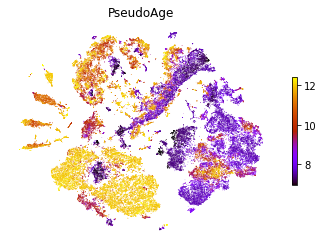

In [44]:
embedding = 'TSNE'

with loompy.connect(f, 'r') as ds:
    fig, ax = plt.subplots()
    age = ds.ca.PseudoAge
    im = ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='gnuplot', c=age, vmin = np.quantile(age, .01), vmax = np.quantile(age, .99), marker='.', lw=0, s=1)
    fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)
    ax.axis("off")
    ax.set_title(f'PseudoAge')
    plt.savefig('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/PseudoAge.png')

11:43:56 INFO     Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


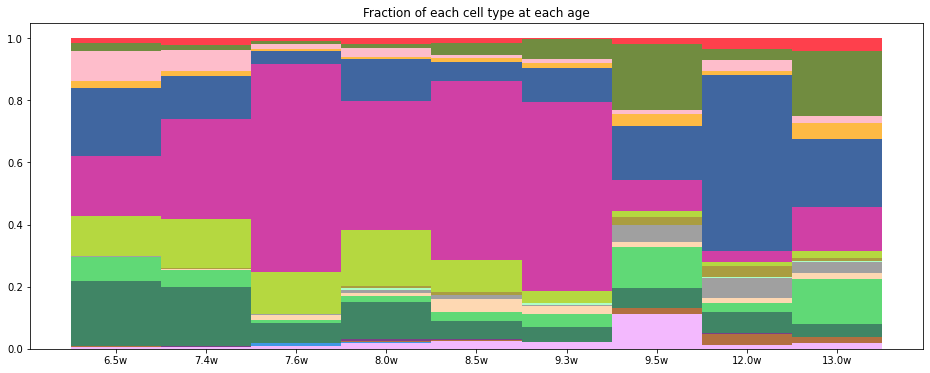

In [46]:
from matplotlib.colors import ListedColormap
from cytograph.plotting.colors import colorize


with loompy.connect(f) as ds:

    Class = np.unique(ds.ca.Class_labels) 
    ages = np.unique(ds.ca.Age)
    df = pd.DataFrame([])

    for i, a in enumerate(ages): 
        cls, cells = np.unique(ds.ca.Class_labels[ds.ca.Age == a], return_counts=True)
        fraction = np.nan_to_num(cells / np.sum(cells))

        d = {c: x for c,x in zip(cls, fraction)}
        d['Age'] =  a
        data = pd.Series(d)
        df = df.append(data, ignore_index=True)
    df = df.fillna(0)
    df.sort_values(by='Age')
    
    color = colorize(Class) 
    colors = colorize(Class)
    cmp = ListedColormap(colors, name='cmp')
    
    fig, ax = plt.subplots(figsize=(16,6))

    width = 1
    bottoms = np.zeros(len(df['Age']))
    for i, cls in enumerate(Class):
        ax.bar(df['Age'].astype(str)+'w', df[cls], width, bottom=bottoms, label=cls, alpha=.75, color=colors[i]);
        bottoms = bottoms + df[cls]
    ax.set_title(f'Fraction of each cell type at each age')
    
#     df.plot(x='Age', kind='bar', stacked=True,
#             ax = ax, colormap = cmp,
#             title='Fraction of cell types at each timepoint')

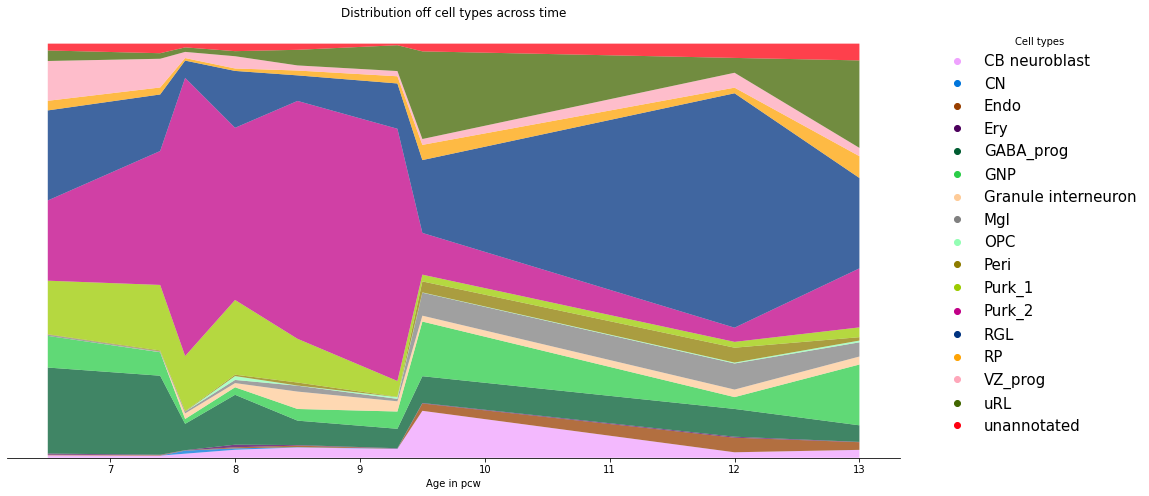

In [47]:
vals = {}

for k, v in sorted(df.items()):
    if k is not 'Age':
        vals[k] = v

color_dict = {k:v for k, v in zip(vals.keys(), colors)}
        
fig, ax = plt.subplots(figsize = (16,8))
ax.stackplot(df['Age'], vals.values(), labels=vals.keys(), colors=colors, alpha=.75);
ax.set_xlabel(f'Age in pcw')
ax.set_title(f'Distribution off cell types across time')
# Remove spines
ax.spines['right'].set_visible(False);
ax.spines['top'].set_visible(False);
ax.spines['left'].set_visible(False);
ax.set_yticks([])

h = lambda c: plt.Line2D([], [], color=c, ls="", marker="o")
legend1 = ax.legend(handles=[h(color_dict[k]) for k in vals.keys()], labels=list(vals.keys()), 
                        bbox_to_anchor=(0.73, 0., 0.55, 1.0), title='Cell types', title_fontsize=10, frameon=False, fontsize=15)
# plt.savefig('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/Cell_type_distribution.png')

In [18]:
f_peaks = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'
f_agg = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.agg.loom'

markers = {}

with loompy.connect(f_peaks, 'r') as ds:
    with loompy.connect(f_agg, 'r') as dsagg:
        print(dsagg.layers.keys())
        print(dsagg.ca.keys())
        for i in range(dsagg.shape[1]):
            x = np.where(dsagg['residuals'][:,i] == np.max(dsagg['residuals'][:,i]))[0]
            markers[dsagg.ca.Class_labels[i]] = x

['', 'CPM', 'binary', 'log2fc', 'marker_peaks', 'residuals']
['Age', 'AutoAnnotation', 'CPM_thres', 'Chemistry_multiome_atac', 'Chemistry_v1', 'Chemistry_v1_1', 'Class', 'Class_labels', 'Clusters_0', 'Clusters_1', 'Clusters_10', 'Clusters_11', 'Clusters_12', 'Clusters_13', 'Clusters_14', 'Clusters_15', 'Clusters_16', 'Clusters_17', 'Clusters_18', 'Clusters_19', 'Clusters_2', 'Clusters_20', 'Clusters_21', 'Clusters_22', 'Clusters_23', 'Clusters_24', 'Clusters_25', 'Clusters_26', 'Clusters_27', 'Clusters_28', 'Clusters_29', 'Clusters_3', 'Clusters_30', 'Clusters_31', 'Clusters_32', 'Clusters_33', 'Clusters_34', 'Clusters_35', 'Clusters_36', 'Clusters_37', 'Clusters_38', 'Clusters_39', 'Clusters_4', 'Clusters_40', 'Clusters_41', 'Clusters_42', 'Clusters_43', 'Clusters_44', 'Clusters_45', 'Clusters_46', 'Clusters_47', 'Clusters_48', 'Clusters_49', 'Clusters_5', 'Clusters_50', 'Clusters_51', 'Clusters_52', 'Clusters_53', 'Clusters_54', 'Clusters_55', 'Clusters_56', 'Clusters_57', 'Clusters_

## Export UMAP etc

In [48]:
f = '/datb/sl/camiel/HARs/CB_Skene/Cerebellum/Cerebellum_peaks.loom'

out = {}

with loompy.connect(f) as ds:
    for k in ds.ca:
        out[k] = ds.ca[k]
        
pkl.dump(out, open('/datb/sl/camiel/HARs/CB_Skene/Cerebellum/exported/column_attr.pkl', 'wb'))

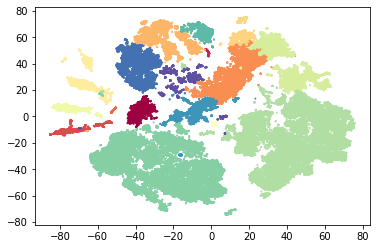

In [49]:
plt.scatter(out['TSNE'][:,0], out['TSNE'][:,1], s=1, c=out['Class'], cmap='Spectral')

In [20]:
import pickle as pkl

data = pkl.load(open(file_name, 'rb'))